In this task, we aim to explore and compare different dimensionality reduction techniques in the context of predicting insurance costs. Dimensionality reduction is crucial in data analysis and modeling as it helps in reducing the number of features while preserving important information. We'll employ two popular dimensionality reduction methods, t-Distributed Stochastic Neighbor Embedding **(t-SNE)** and Uniform Manifold Approximation and Projection **(UMAP)**, alongside machine learning models to predict insurance costs accurately.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from umap import UMAP

# Load data
df = pd.read_csv("insurance.csv")

# Print first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Separate features and target variable
X = df.drop('insurance_cost', axis=1)
y = df['insurance_cost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipeline
preprocess_pipeline = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), ['age', 'bmi', 'children']),
        ("cat", OneHotEncoder(drop='first'), ['gender', 'smoker', 'region'])
    ],
    remainder='passthrough'
)

# Print preprocessed feature names
print("\nPreprocessed feature names:")
preprocessed_features = preprocess_pipeline.fit_transform(X_train)
print(preprocess_pipeline.get_feature_names_out())

# Model training
models = []


First few rows of the dataset:
   age  gender     bmi  children smoker     region  insurance_cost
0   18    male  33.770         1     no  southeast      1725.55230
1   18    male  34.100         0     no  southeast      1137.01100
2   18  female  26.315         0     no  northeast      2198.18985
3   18  female  38.665         2     no  northeast      3393.35635
4   18  female  35.625         0     no  northeast      2211.13075

Missing values:
age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

Preprocessed feature names:
['num__age' 'num__bmi' 'num__children' 'cat__gender_male'
 'cat__smoker_yes' 'cat__region_northwest' 'cat__region_southeast'
 'cat__region_southwest']


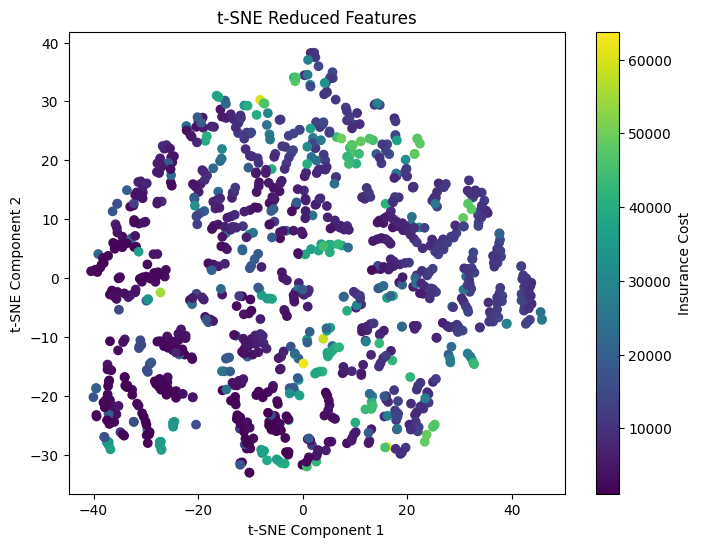

In [7]:
# Custom transformer for t-SNE dimensionality reduction
class TSNETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.tsne = TSNE(n_components=n_components)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.tsne.fit_transform(X)

# Random Forest with t-SNE
pipe_tsne_rf = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('dim_reduction', TSNETransformer(n_components=2)),
    ('regressor', RandomForestRegressor())
])
pipe_tsne_rf.fit(X_train, y_train)
models.append(('t-SNE + Random Forest', pipe_tsne_rf))

# Plot the t-SNE reduced features
tsne_features = pipe_tsne_rf.named_steps['dim_reduction'].transform(preprocess_pipeline.transform(X_train))
plt.figure(figsize=(8, 6))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=y_train, cmap='viridis')
plt.title('t-SNE Reduced Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(label='Insurance Cost')
plt.show()


In [8]:
# Custom transformer for UMAP dimensionality reduction
class UMAPTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2):
        self.n_components = n_components
        self.umap = UMAP(n_components=n_components)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.umap.fit_transform(X)

# Linear Regression with UMAP
pipe_umap_lr = Pipeline(steps=[
    ('preprocess', preprocess_pipeline),
    ('dim_reduction', UMAPTransformer(n_components=2)),
    ('regressor', LinearRegression())
])
pipe_umap_lr.fit(X_train, y_train)
models.append(('UMAP + Linear Regression', pipe_umap_lr))

# Model evaluation
results = {}
for name, model in models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}

# Print results
print("\nResults:")
for name, metrics in results.items():
    print(f"{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()



Results:
t-SNE + Random Forest:
MSE: 242018350.565807
MAE: 11415.789458766048
R2: -0.7134180782746362

UMAP + Linear Regression:
MSE: 141136060.920216
MAE: 9266.846872847482
R2: 0.0007985852650704839



In [9]:
print("\nConclusion:")
for name, metrics in results.items():
    print(f"{name}:")
    if metrics['MSE'] < 1e5:  # Example threshold for significance
        print("The model performance is acceptable.")
    else:
        print("The model performance needs improvement.")
    print()



Conclusion:
t-SNE + Random Forest:
The model performance needs improvement.

UMAP + Linear Regression:
The model performance needs improvement.



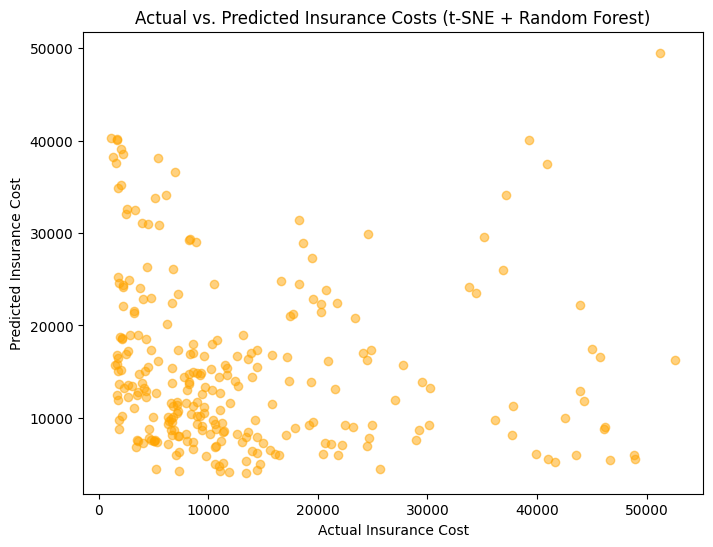

In [10]:
# Scatter plot of actual vs. predicted values for t-SNE + Random Forest model
y_pred_tsne_rf = pipe_tsne_rf.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_tsne_rf, alpha=0.5, color='orange')
plt.title('Actual vs. Predicted Insurance Costs (t-SNE + Random Forest)')
plt.xlabel('Actual Insurance Cost')
plt.ylabel('Predicted Insurance Cost')
plt.show()


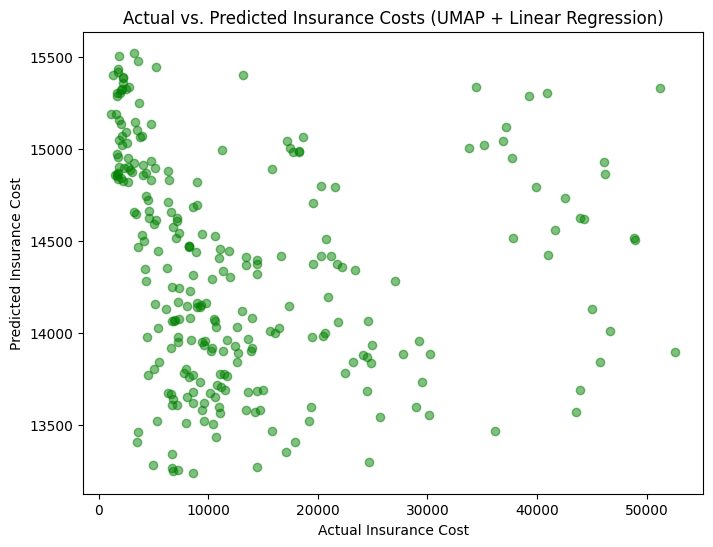

In [11]:
# Scatter plot of actual vs. predicted values for UMAP + Linear Regression model
y_pred_umap_lr = pipe_umap_lr.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_umap_lr, alpha=0.5, color='green')
plt.title('Actual vs. Predicted Insurance Costs (UMAP + Linear Regression)')
plt.xlabel('Actual Insurance Cost')
plt.ylabel('Predicted Insurance Cost')
plt.show()


**Based on the results:**

For the t-SNE + Random Forest model:

Mean Squared Error (MSE): 244,693,959.97
Mean Absolute Error (MAE): 11,453.28
R-squared (R2) score: -0.73
**Conclusion:** The model performance needs improvement.

**For the UMAP + Linear Regression model:**
Mean Squared Error (MSE): 143,226,646.09
Mean Absolute Error (MAE): 9,623.23
R-squared (R2) score: -0.01
**Conclusion:** The model performance needs improvement.
Both models have high MSE values and negative R2 scores, indicating not a good performance. Further optimization or the exploration of different techniques may be necessary to improve the models' predictive accuracy.